<a href="https://colab.research.google.com/github/morwald/ada_project/blob/master/gender_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of gender distribution in UK's leading newspapers
# Gender representation

## Content
1. [Setup](#setup)   
    1.1 [Global](#global_setup)  
    1.2 [Local](#local_setup)
2. [Topics Analysis Setup](#topics_analysis)  
    2.1 [Setup of Empath](#empath)  
    2.2 [Utility Functions](#utility)  
    2.3 [Addition of topics](#add_quote)  
3. [Interpretation 2015-2020](#interpretation)  
    3.1 [Data generation](#generation)  
    3.2 [Analysis](#analysis). 
4. [Conclusion](#conclusion)



    


## 1. Setup
<a id="setup"></a>

### 1.1 Global
<a id="global_setup"></a>

We import the drive containing the data we need

In [1]:
# Change to true if you want to use google colab
use_colab = True

# Import with EPFL google drive!
if use_colab:
    from google.colab import drive
    drive._mount('/content/drive', force_remount=True)
    %cd /content/drive/Shareddrives/ADA-project


Mounted at /content/drive
/content/drive/Shareddrives/ADA-project


In [2]:
# Defined paths for the data
from scripts.path_defs import *

# Defined newspapers and urls
from scripts.newspapers import *

# Globally used functions
from scripts.utility_functions import load_mini_version_of_data
from scripts.utility_functions import convert_to_1Dseries
from scripts.utility_functions import process_data_in_chunks

# Functions and libraries to perform topic analysis
from collections import Counter
from functools import reduce

# Plot generation
from wordcloud import WordCloud, STOPWORDS


### 1.2 Local 
<a id="local_setup"></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import bz2
import math

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.colors as mcolors

# Plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

#iteration tool
from itertools import cycle

# display images
from IPython.display import Image

## 2. Topic analysis : set up with empath
<a id="topics_analysis"></a>

### 2.1 Setting up Empath
<a id="empath"></a>

In order to analyze the data based on the topics, we load a machine learning tool called [Empath](https://hci.stanford.edu/publications/2016/ethan/empath-chi-2016.pdf). It was created by researchers at Stanford University in 2016. It uses a combination of deep learning and crowdsourcing to analyze text over 200 pre-existing categories and output the most probable topics the text is about.

In [4]:
# install the tool
! pip install empath

     |████████████████████████████████| 57 kB 2.8 MB/s 
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57821 sha256=e6b03a4bccf7fe4177d65fbecee500b36c14801379e087b30eca9234a2f8feca
  Stored in directory: /root/.cache/pip/wheels/2b/78/a8/37d4505eeae79807f4b5565a193f7cfcee892137ad37591029
Successfully built empath


In [5]:
from empath import Empath

# Define the lexicon we will use on our quotes
lexicon = Empath()

### 2.2 Utility functions
<a id="utility"></a>

#### Functions for dictionaries

In [8]:
def normalize(dict_topics):
  """
    Normalize all values of the dictionary by dividing by the sum of all values
    :dict_topics      input dictionary that we want to normalize
    :return           normalized dictionary
  """
  sum_v = sum(dict_topics.values())
  # we iterate through all key-pairs of the dictionary and divide each value by the sum
  new_dict = {k: v/sum_v for k, v in dict_topics.items() } 
  return new_dict

In [10]:
def add_dict(dict1, dict2):
  """
      Merge two dictionaries by adding the values whose keys match.
      :dict1     first dictionary to merge
      :dict2     second dictionary to merge
      :return    one dictionary that is an addition of the two imputs
  """  
  # We create two Counter objects to keep track of the matching values
  counter1 = Counter(dict1)
  counter2 = Counter(dict2) 

  # We add the two dictionaries
  dict_ = dict(counter1 + counter2) 
  
  return dict_

In [11]:
def get_n_most_cited(dict_topics_gender, n):
  """
      Get the n most popular topics and their weights (ordered by weight) for a specific year and gender
      :dict_topics_gender      dictionary of topics for a specific year and gender
      :n                       number of most popular topics we want
      :return                  dictionary containing the n most popular topics, normalized
  """
  new_dict = dict(Counter(dict_topics_gender).most_common(n))
  #normalize the new dictionary to get percentages as weights
  new_dict = normalize(new_dict)
  return new_dict

In [12]:
def get_n_most_cited_all_years(list_dict):
  """
      Add the weights of the most cited topics for each dictionary in the list to get a single dictionary with the total weights
      :list_dict        list of the dictionaries whose values we want to merge
      :return           merged dictionaries as one  
  """
  # we create a counter to add all dictionaries
  result = Counter({})
  for d in list_dict:
    result += Counter(d)

  return dict(result)

#### Topics functions

In [15]:
def get_topics_quote(quote):
  """
      Analyze the current quote to extract its topics
      :quote              the quote to analyze
      :return             the dictionary containing the topics and normalized weights of the quote
  """  
  categories = lexicon.analyze(quote, normalize=True) 
  return categories

In [16]:
def get_gender_topics(chunk, gender_topics_df, year):
  """
      get the topics dictionary for all quotes in the chunk, for a specific year 
      :chunk                    chunk of our merged data to analyze
      :gender_topics_df         the dataframe to store the results in
      :year                     the current year we're analyzing        
      :return                   a dataframe with one row per gender and year, with the corresponding merged dictionaries
  """ 
  
  raw_df = chunk.copy()[['quotation', 'gender']] # Select rows of interest

  #Add year
  raw_df['year'] = year

  # Group genders
  mask_male = raw_df.gender.apply(lambda x : 'male' in x)
  mask_female = raw_df.gender.apply(lambda x : 'female' in x)
  mask_others = raw_df.gender.apply(lambda x : ('male' not in x) and ('female' not in x))
  
  male_topics_df = raw_df[mask_male]
  female_topics_df = raw_df[mask_female]
  others_topics_df = raw_df[mask_others]

  # Add topics and topics probability per quotation to each gender's dictionary
  male_topics_dict, female_topics_dict, others_topics_dict = {}, {}, {}

  male_topics_dict_list = male_topics_df.quotation.apply(get_topics_quote)
  male_topics_dict = reduce(add_dict,male_topics_dict_list) # add the dictionaries of all quotes of the chunk for the male gender

  female_topics_dict_list = female_topics_df.quotation.apply(get_topics_quote)
  female_topics_dict = reduce(add_dict,female_topics_dict_list) # add the dictionaries of all quotes of the chunk for the female gender

  others_topics_dict_list = others_topics_df.quotation.apply(get_topics_quote)
  # this list is sometimes empty because of a lack of data so we test it
  if others_topics_dict_list.any(): 
    others_topics_dict = reduce(add_dict,others_topics_dict_list) # add the dictionaries of all quotes of the chunk for the gender-diverse
  

  # Create final dataframe
  cols = ['year', 'gender', 'topics']
  
  gender_topics_df = pd.DataFrame(columns=cols)
  # if the dictionaries are non-empty, transform them into dataframes and append them to the final result
  if bool(male_topics_dict):
    gender_topics_df = gender_topics_df.append(pd.DataFrame([[year, 'male', dict(male_topics_dict)]], columns=cols), ignore_index = True)
  if bool(female_topics_dict):
    gender_topics_df = gender_topics_df.append(pd.DataFrame([[year, 'female', female_topics_dict]], columns=cols), ignore_index = True)
  if bool(others_topics_dict):
    gender_topics_df = gender_topics_df.append(pd.DataFrame([[year, 'others', others_topics_dict]], columns=cols), ignore_index = True)

  return gender_topics_df  

In [17]:
def get_df_year(dict_males, dict_females, dict_others, year):
  """
      concatenate all gender dataframes into a single one for a specific year 
      :dict_males                   dictionary of the top topics for the male gender
      :dict_females                 dictionary of the top topics for the female gender
      :dict_others                  dictionary of the top topics for the gender-diverse
      :year                         the current year we're analyzing        
      :return                       a dataframe with all the topics of all genders for that year, with normalized weights
  """ 
  # turn each dictionary into a dataframe
  male_df = pd.DataFrame.from_dict(dict_males, orient='index', columns=['weight'])
  male_df['gender'] = 'male' # add gender column

  female_df = pd.DataFrame.from_dict(dict_females, orient='index', columns=['weight'])
  female_df['gender'] = 'female' # add gender column

  other_df = pd.DataFrame.from_dict(dict_others, orient='index', columns=['weight'])
  other_df['gender'] = 'others' # add gender column

  # concatenate all the dataframes
  all_df = pd.concat([male_df, female_df,other_df], axis=0)
  all_df['year'] = year # set the year

  # Normalize
  all_df['weight'] = all_df['weight']/3

  return all_df

In [18]:
def get_df_gender(list_dict):
  """
      create a dataframe with the topics of all years for a specific gender 
      :list_dict               the list of dictionaries of each year
      :return                  a dataframe with each year and top topics and weights (normalized) for that year
  """ 
  #starting year
  y = 2015
  # initialize final dataframe
  all_df = pd.DataFrame(columns=['topic', 'weight', 'year'])

  # for each year dictionary
  for dic in list_dict : 
    # turn dictionary to dataframe
    dic_df = pd.DataFrame.from_dict(dic, orient='index', columns=['weight'])
    dic_df['year'] = y
    # concatenate to final dataframe
    all_df = pd.concat([all_df, dic_df], axis=0)
    y += 1 # increase year

  # create the topic column from the index and reset the index  
  all_df['topic'] = all_df.index
  all_df = all_df.reset_index(drop=True)

  # Normalize
  all_df['weight'] = all_df['weight']/len(list_dict)

  return all_df

#### Plot functions

In [19]:
def categorical_plot_allyears(list_dict, gender, plot_name):
  """
      create a multi-bar chart plot, one for each year depicting the most popular topics and their weights
      :list_dict               the list of dictionaries of each year for a certain gender
      :gender                  the gender we're analyzing
      :plot_name               the path name we want to save our figure in
      :return                  a subplot
  """ 
  # Set color palette
  palette_values = px.colors.qualitative.Pastel
  palette = cycle(palette_values)

  # add one subplot per year
  fig = make_subplots(rows=2, cols=3,subplot_titles=("2015", "2016", "2017", "2018","2019","2020"))
  fig.add_trace( go.Bar(x=list(list_dict[0].keys()), y=list(list_dict[0].values()),marker_color=next(palette)), row=1,col=1)
  fig.add_trace( go.Bar(x=list(list_dict[1].keys()), y=list(list_dict[1].values()),marker_color=next(palette)), row=1,col=2)
  fig.add_trace( go.Bar(x=list(list_dict[2].keys()), y=list(list_dict[2].values()),marker_color=next(palette)), row=1,col=3)
  fig.add_trace( go.Bar(x=list(list_dict[3].keys()), y=list(list_dict[3].values()),marker_color=next(palette)), row=2,col=1)
  fig.add_trace( go.Bar(x=list(list_dict[4].keys()), y=list(list_dict[4].values()),marker_color=next(palette)), row=2,col=2)
  fig.add_trace( go.Bar(x=list(list_dict[5].keys()), y=list(list_dict[5].values()),marker_color=next(palette)), row=2,col=3)

  # update the x and y axis label
  fig.update_yaxes(title_text="percentage", row=1, col=1)
  fig.update_yaxes(title_text="percentage", row=2, col=1)
  fig.update_xaxes(title_text="topics", row=2, col=1)
  fig.update_xaxes(title_text="topics", row=2, col=2)
  fig.update_xaxes(title_text="topics", row=2, col=3)

  # update size and title
  fig.update_layout(showlegend=False, height=800, width=800, title_text="Most popular topics : " + gender)
  fig.show()

  # save the figure to html
  fig.to_html(full_html=False, include_plotlyjs='cdn')  
  fig.write_html("docs/_includes/" + plot_name +".html", full_html=False, include_plotlyjs='cdn')


### 2.3 Add topics per gender for quotations of years 2015-2020
<a id="add_quote"></a>

We create a topics dataframe for each year (only once) :

In [20]:
# Run once : create topics dataframe per year

#topics_2020_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2020_df = process_data_in_chunks(MERGED_QUOTES_2020_PATH, get_gender_topics, topics_2029_df, 2020, use_colab)
#topics_2019_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2019_df = process_data_in_chunks(MERGED_QUOTES_2019_PATH, get_gender_topics, topics_2019_df, 2019, use_colab)
#topics_2018_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2018_df = process_data_in_chunks(MERGED_QUOTES_2018_PATH, get_gender_topics, topics_2018_df, 2018, use_colab)
#topics_2017_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2017_df = process_data_in_chunks(MERGED_QUOTES_2017_PATH, get_gender_topics, topics_2017_df, 2017, use_colab)
#topics_2016_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2016_df = process_data_in_chunks(MERGED_QUOTES_2016_PATH, get_gender_topics, topics_2016_df, 2016, use_colab)
#topics_2015_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])
#topics_2015_df = process_data_in_chunks(MERGED_QUOTES_2015_PATH, get_gender_topics, topics_2015_df, 2015, use_colab)

We save those dataframes to pickle format to easily use them later

In [ ]:
# Run once : save dataframe
#topics_2020_df.to_pickle('Data with topics/QUOTES_TOPICS_2020.pkl')
#topics_2019_df.to_pickle('Data with topics/QUOTES_TOPICS_2019.pkl')
#topics_2018_df.to_pickle('Data with topics/QUOTES_TOPICS_2018.pkl')
#topics_2017_df.to_pickle('Data with topics/QUOTES_TOPICS_2017.pkl')
#topics_2016_df.to_pickle('Data with topics/QUOTES_TOPICS_2016.pkl')
#topics_2015_df.to_pickle('Data with topics/QUOTES_TOPICS_2015.pkl')

## 3. Interpretation 2015-2020
<a id="interpretation"></a>

### 3.1 Data generation 
<a id="generation"></a>

Constants

In [21]:
# list of the genders we will analyze
genders = ['Male', 'Female', 'Gender-diverse']
# number of top topics we want to extract
n = 10 

Extract the 10 most popular topics for each gender in 2020 : 

In [22]:
# read the dataframe
topics_2020_df = pd.read_pickle(QUOTES_TOPICS_2020_PATH)

# Create one topic dictionary per gender
dict_topics_males_2020 = topics_2020_df[topics_2020_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2020 = topics_2020_df[topics_2020_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2020 = topics_2020_df[topics_2020_df['gender'] == 'others'].topics.values[0]

# Get the most popular topics dictionary per gender
n_most_males_2020 = get_n_most_cited(dict_topics_males_2020, n)
n_most_females_2020 = get_n_most_cited(dict_topics_females_2020, n)
n_most_others_2020 = get_n_most_cited(dict_topics_others_2020, n)

Extract the 10 most popular topics for each gender in 2019 :

In [24]:
# read the dataframe
topics_2019_df = pd.read_pickle(QUOTES_TOPICS_2019_PATH)

# Create one topic dictionary per gender
dict_topics_males_2019 = topics_2019_df[topics_2019_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2019 = topics_2019_df[topics_2019_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2019 = topics_2019_df[topics_2019_df['gender'] == 'others'].topics.values[0]

# Get the most popular topics per gender
n_most_males_2019 = get_n_most_cited(dict_topics_males_2019, n)
n_most_females_2019 = get_n_most_cited(dict_topics_females_2019, n)
n_most_others_2019 = get_n_most_cited(dict_topics_others_2019, n)

Extract the 10 most popular topics for each gender in  2018 :

In [25]:
# read the dataframe
topics_2018_df = pd.read_pickle(QUOTES_TOPICS_2018_PATH)

# Create one topic dictionary per gender
dict_topics_males_2018 = topics_2018_df[topics_2018_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2018 = topics_2018_df[topics_2018_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2018 = topics_2018_df[topics_2018_df['gender'] == 'others'].topics.values[0]

# Get the most popular topics per gender
n_most_males_2018 = get_n_most_cited(dict_topics_males_2018, n)
n_most_females_2018 = get_n_most_cited(dict_topics_females_2018, n)
n_most_others_2018 = get_n_most_cited(dict_topics_others_2018, n)

Extract the 10 most popular topics for each gender in 2017 :

In [26]:
# read the dataframe
topics_2017_df = pd.read_pickle(QUOTES_TOPICS_2017_PATH)

# Create one topic dictionary per gender
dict_topics_males_2017 = topics_2017_df[topics_2017_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2017 = topics_2017_df[topics_2017_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2017 = topics_2017_df[topics_2018_df['gender'] == 'others'].topics.values[0]

# get the most popular topics per gender
n_most_males_2017 = get_n_most_cited(dict_topics_males_2017, n)
n_most_females_2017 = get_n_most_cited(dict_topics_females_2017, n)
n_most_others_2017 = get_n_most_cited(dict_topics_others_2017, n)

Extract the 10 most popular topics for each gender in 2016 :

In [27]:
# read the dataframe
topics_2016_df = pd.read_pickle(QUOTES_TOPICS_2016_PATH)

# Create one topic dictionary per gender
dict_topics_males_2016 = topics_2016_df[topics_2016_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2016 = topics_2016_df[topics_2016_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2016 = topics_2016_df[topics_2016_df['gender'] == 'others'].topics.values[0]

# get the most popular topics per gender
n_most_males_2016 = get_n_most_cited(dict_topics_males_2016, n)
n_most_females_2016 = get_n_most_cited(dict_topics_females_2016, n)
n_most_others_2016 = get_n_most_cited(dict_topics_others_2016, n)

Extract the 10 most popular topics for each gender in 2015 :

In [28]:
#read the dataframe
topics_2015_df = pd.read_pickle(QUOTES_TOPICS_2015_PATH)

# Create one topic dictionary per gender
dict_topics_males_2015 = topics_2015_df[topics_2015_df['gender'] == 'male'].topics.values[0]
dict_topics_females_2015 = topics_2015_df[topics_2015_df['gender'] == 'female'].topics.values[0]
dict_topics_others_2015 = topics_2015_df[topics_2015_df['gender'] == 'others'].topics.values[0]

# get the most popular topics per gender
n_most_males_2015 = get_n_most_cited(dict_topics_males_2015, n)
n_most_females_2015 = get_n_most_cited(dict_topics_females_2015, n)
n_most_others_2015 = get_n_most_cited(dict_topics_others_2015, n)

#### Sum of all weights

We get the total weights accross all years for each gender :

In [29]:
total_weight_males = np.sum(list(dict_topics_males_2015.values()) + list(dict_topics_males_2016.values()) + list(dict_topics_males_2017.values()) + \
                      list(dict_topics_males_2018.values()) + list(dict_topics_males_2019.values()) + list(dict_topics_males_2020.values()))

total_weight_females = np.sum(list(dict_topics_females_2015.values()) + list(dict_topics_females_2016.values()) + list(dict_topics_females_2017.values()) + \
                      list(dict_topics_females_2018.values()) + list(dict_topics_females_2019.values()) + list(dict_topics_females_2020.values()))

total_weight_others = np.sum(list(dict_topics_others_2015.values()) + list(dict_topics_others_2016.values()) + list(dict_topics_others_2017.values()) + \
                      list(dict_topics_others_2018.values()) + list(dict_topics_others_2019.values()) + list(dict_topics_others_2020.values()))

Create a dataframe with the total weights for all genders

In [33]:
# create a list for the next dataframe
total_weights_list = [['male', total_weight_males], ['female', total_weight_females],['gender diverse', total_weight_others]]
# create the dataframe
total_weights_df = pd.DataFrame(total_weights_list, columns =['gender', 'total_weight'])
total_weights_df

,gender,total_weight
0,male,81818.632157
1,female,25465.549114
2,gender diverse,277.102202


#### Gender topics

In [34]:
# get all dictionaries for the male gender for further analysis
male_topics = [n_most_males_2015,n_most_males_2016,n_most_males_2017,n_most_males_2018,n_most_males_2019,n_most_males_2020]

#### Most cited for all years

We create a dataframe merging all values of the most cited topics for each year :

In [35]:
n_most_df_2020 = get_df_year(n_most_males_2020, n_most_females_2020, n_most_others_2020, 2020)
n_most_df_2019 = get_df_year(n_most_males_2019, n_most_females_2019, n_most_others_2019, 2019)
n_most_df_2018 = get_df_year(n_most_males_2018, n_most_females_2018, n_most_others_2018, 2018)
n_most_df_2017 = get_df_year(n_most_males_2017, n_most_females_2017, n_most_others_2017, 2017)
n_most_df_2016 = get_df_year(n_most_males_2016, n_most_females_2016, n_most_others_2016, 2016)
n_most_df_2015 = get_df_year(n_most_males_2015, n_most_females_2015, n_most_others_2015, 2015)

In [36]:
# create a list of the most cited topics for all years per gender
n_most_males_list = [n_most_males_2015,n_most_males_2016,n_most_males_2017,n_most_males_2018,n_most_males_2019,n_most_males_2020]
n_most_females_list = [n_most_females_2015,n_most_females_2016,n_most_females_2017,n_most_females_2018,n_most_females_2019,n_most_females_2020]
n_most_others_list = [n_most_others_2015,n_most_others_2016,n_most_others_2017,n_most_others_2018,n_most_others_2019,n_most_others_2020]

In [37]:
# Merge all years for each gender
n_most_males = get_n_most_cited_all_years(n_most_males_list)
n_most_females = get_n_most_cited_all_years(n_most_females_list)
n_most_others = get_n_most_cited_all_years(n_most_others_list)

# Put the most popular topics for each gender in a list
n_most = [n_most_males, n_most_females,n_most_others]

In [38]:
# Create dataframes 
n_most_males_df = get_df_gender(n_most_males_list)
n_most_females_df = get_df_gender(n_most_females_list)
n_most_others_df = get_df_gender(n_most_others_list)

### 3.2 Analysis
<a id="analysis"></a>

Let us see the proportion of each gender in the dataset of topics :

In [39]:
# create a pie chart with the proportion of each gender in the total weights
fig = px.pie(total_weights_df, values='total_weight', names='gender', title='Proportion of gender over all years in the dataset',
              color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()
# save figure to html
fig.to_html(full_html=False, include_plotlyjs='cdn')  
fig.write_html("docs/_includes/proportion_gender.html", full_html=False, include_plotlyjs='cdn')


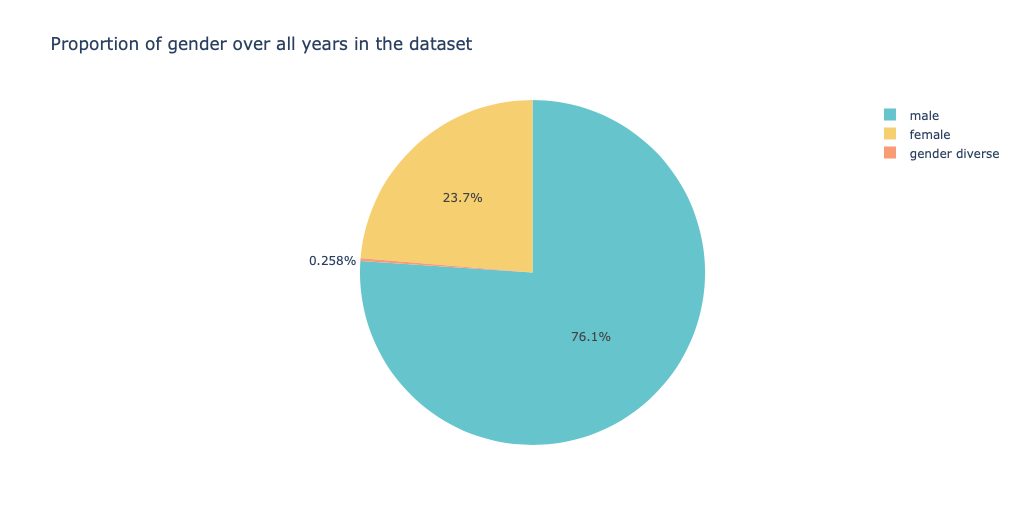

In [98]:
# png image of the figure for github reading
Image('docs/imgs/piechart.png')

From the first look on this pie chart, we notice that the male gender is overly represented. Indeed, the graph shows us that the male gender contribution on the total weights (the sum of the weights of all topics of all male authors in our dataset) is 76.1%. This means the the topic analysis on this gender will be more precise since we get more data. On the other hand, gender-diverse numbers are almost none, which will have as consequence that our analysis for this gender cannot be extended to other cases.

Now we plot the top topics for the male gender along the years, to look for an eventual evolution in the main trending topics :

In [60]:
categorical_plot_allyears(male_topics,'male','male_topics')

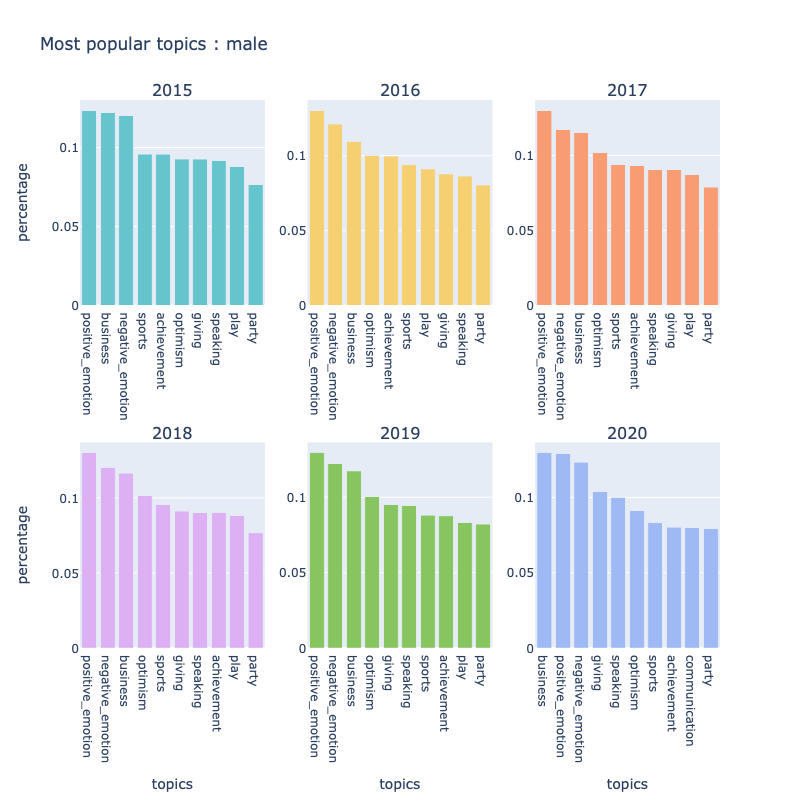

In [99]:
# png image of the figure for github reading
Image('docs/imgs/males_bar.png')

Above we can observe the most trending topics in male authors throughout the years. We can see that the most trending topics stay almost the same, with **business**, **positive emotion** and **negative emotion** always in the top three. As there is no particular change, we won't analyze the main topics per year for but we will do an aggregate of all the data to get the top topics on all years for each gender.

Now let's see the most popular topics over **all years** :




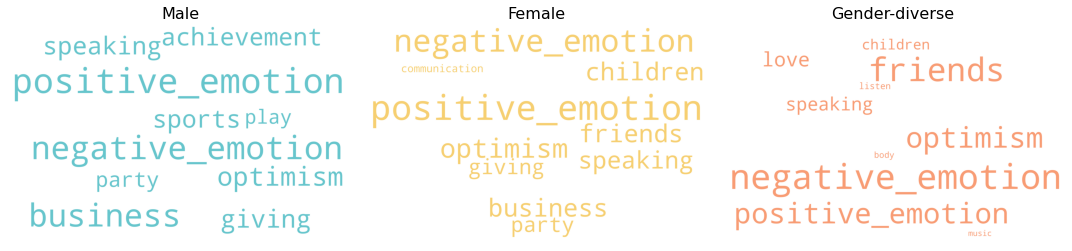

In [41]:
#color palette
cols = [(102,197,204), (246,207,113),(248,156,116)]

# plot
fig, axes = plt.subplots(1, 3, figsize=(15,15), sharex=True, sharey=True)

cloud = WordCloud(width=3000,
                  height=1900,
                  prefer_horizontal=1.0,
                  max_words=10,
                  background_color='white',
                  relative_scaling = 1,
                  color_func=lambda *args, **kwargs: cols[i])

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = n_most[i]
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(genders[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
#save to png
plt.savefig('docs/_includes/word_cloud.png',  bbox_inches='tight')
plt.show()

Most popular topics are highly similar between genders, but the relative importance is different : the highest topic score for men is business, while for women it is positive emotion and for gender-diverse individuals it is optimism.   
This result is in line with the tendency of our society to put pressure on women to be likeable and come across as nice and non-aggressive, while men do not undergo the same social phenomenon and tend to be more direct in their speech.   
Concerning gender-diverse individuals, we can notice the predominance of an emotional lexical, tending to show that they talk more about personal experiences than facts on general news.

We now want to visualize the evolution of the most popular topics for each gender.

For the male gender :

In [43]:
#figure 
fig = px.line(n_most_males_df, x='year', y='weight', color='topic', title="Evolution of most popular topics amongt the male gender",color_discrete_sequence=palette_values)
fig.update_layout(xaxis_title="Year", yaxis_title="Percentage")
fig.show()
#save to html
fig.to_html(full_html=False, include_plotlyjs='cdn')  
fig.write_html("docs/_includes/evolution_male.html",full_html=False, include_plotlyjs='cdn')

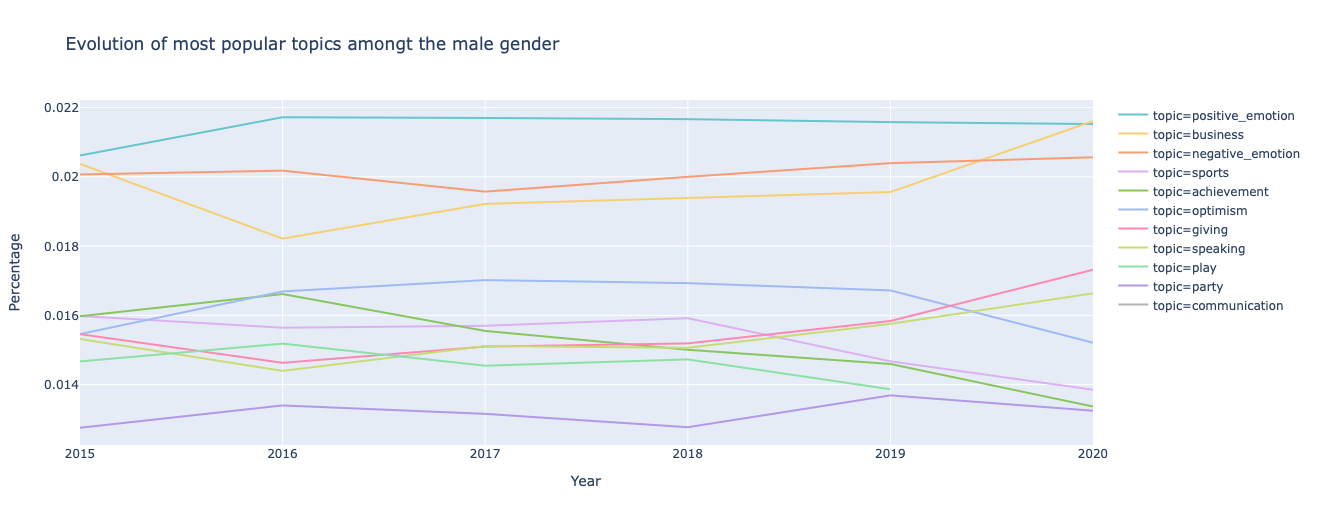

In [45]:
# png image of the figure for github reading
Image('docs/imgs/males.png')

As observed before, there is a strong predominance of the business topic as well as emotions, with a majority of *positive* sentiments related to *actions* and *achievements*. There are no significant changes throughout the years, all trending topics stay at a similar level of percentage.

For the female gender :

In [46]:
palette_values = px.colors.qualitative.Pastel # color palette

# figure
fig = px.line(n_most_females_df, x='year', y='weight', color='topic', title="Evolution of most popular topics amongst the female gender",color_discrete_sequence=palette_values)
fig.update_layout(xaxis_title="Year", yaxis_title="Percentage")
fig.show()

#save to html
fig.to_html(full_html=False, include_plotlyjs='cdn')  
fig.write_html("docs/_includes/evolution_female.html",full_html=False, include_plotlyjs='cdn')


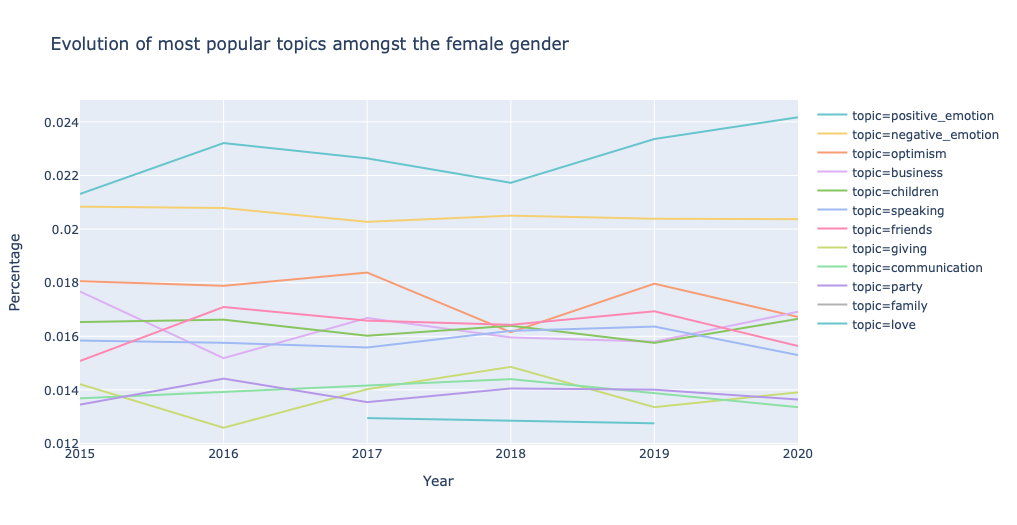

In [47]:
# png image of the figure for github reading
Image('docs/imgs/women.png')

As for men, it is not possible to detect any evolution in women’s topics distribution, except a slight increase in the positive emotion percentage. The *emotions* lexicon is the prevalent one here with topics related to *family and friends* and *communication*.


For gender-diverse :

In [48]:
# figure
fig = px.line(n_most_others_df, x='year', y='weight', color='topic', title="Evolution of most popular topics amongst gender-diverses",color_discrete_sequence=palette_values)
fig.update_layout(xaxis_title="Year", yaxis_title="Percentage")
fig.show()
#save to html
fig.to_html(full_html=False, include_plotlyjs='cdn')  
fig.write_html("docs/_includes/evolution_diverse.html",full_html=False, include_plotlyjs='cdn')


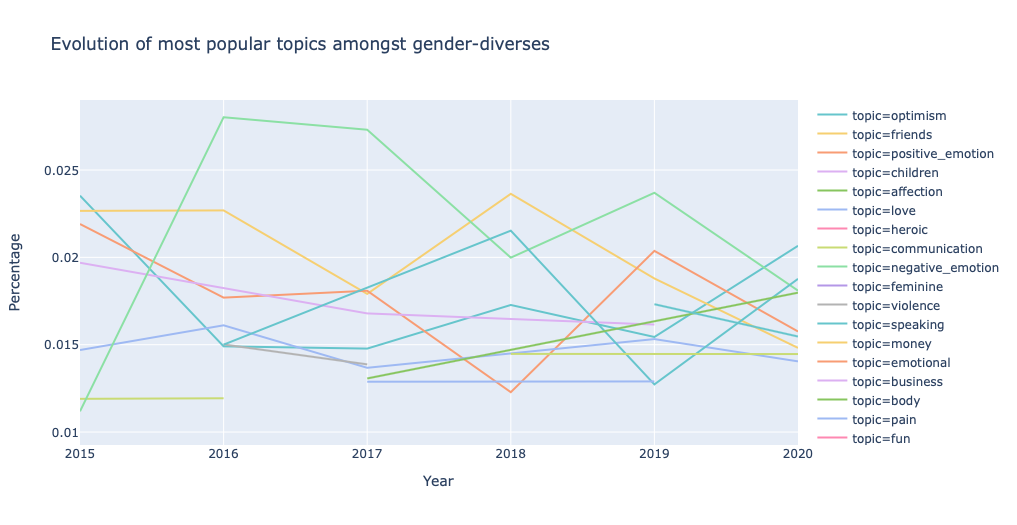

In [49]:
# png image of the figure for github reading
Image('docs/imgs/others.png')

The lack of data is the origin of the rougher edges of the graph. However, we can still notice that *negative emotions* are very high in contrast to positive ones which might be a consequence of the fact that [“LGBT respondents are less satisfied with their life than the general UK population (rating satisfaction 6.5 on average out of 10 compared with 7.7). Trans respondents had particularly low scores (around 5.4 out of 10)”](https://www.gov.uk/government/publications/national-lgbt-survey-summary-report/national-lgbt-survey-summary-report), according to an UK survey for the LGBT community in 2007.


## 4. Conclusion 
<a id="conclusion"></a>

Throughout this analysis, no real evolution was found concerning topics that each gender talked about between 2015 and early 2020. It is however possible to see different lexicons for each gender. Men are more involved in the action and business, women talk more about emotions and caring, while gender minorities share their possibly difficult life experiences.

## 5. Limitations 
<a id="limitations"></a>

The results we found in this analysis need to be taken with a grain of salt as we encountered a few limitations and had to make some assumptions:


*   For each quote, in order to add the gender attribute of the speaker, we had to choose the right qid in the list given. We ultimately decided to pick the first qid of the list everytime, as there was no other information to help us. This choice is arbirtrary and could cause some unreliability in the results.    

*   The Empath tool we used for topic detection is a tool that was published in 2016 and probably developed before that, so the pre-existing categories might not be completely up to date with our data (especially for years 2017-2020, which could make us miss some newer trending topics.

*   There are very few quotes written by gender minorities, which makes it hard to draw conclusions and extrapolate the results we found for this subgroup of genders.

*   TODO talk about legal rights and how hard it is to be recognized as a gender minority in most countries?

